<h1>Pytorch로 직접 짜보는 AlexNet</h1>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12KRhFY64TcmdGl89pkBE0VOt-OYaBW4Z#scrollTo=lHJs7GjUbFfH)

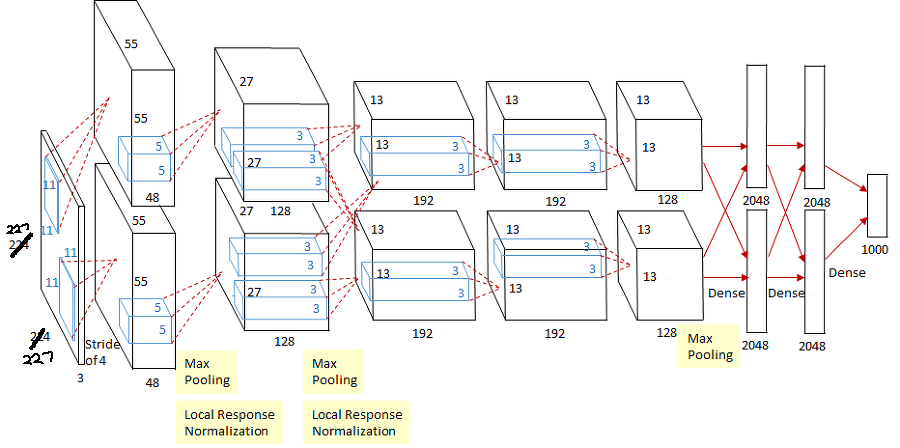

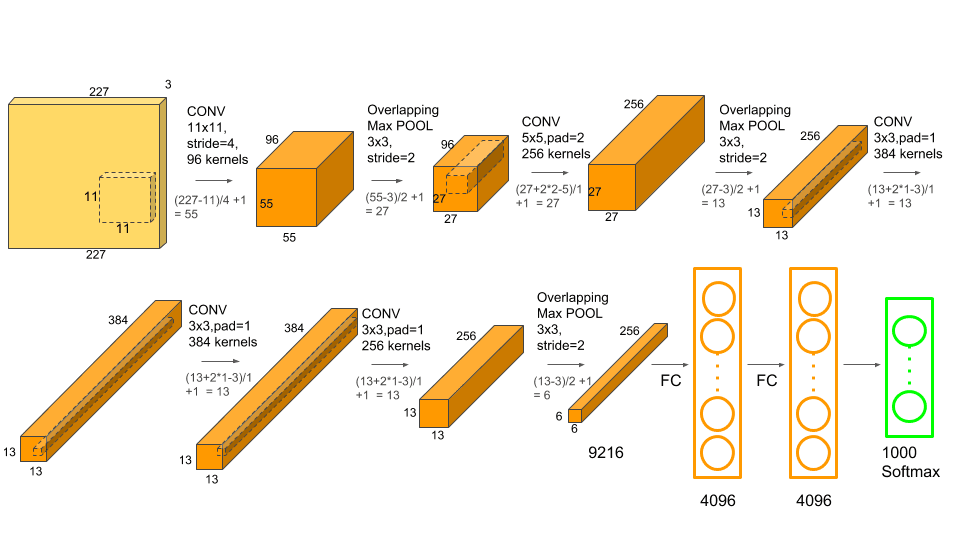

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms, datasets
import torch.optim as optim
import torchvision

# import zipfile
# import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.net = nn.Sequential(
                                  nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
                                  nn.ReLU(inplace=True),
                                  nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # LRN
                                  nn.MaxPool2d(kernel_size=3, stride=2),

                                  nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
                                  nn.ReLU(inplace=True),
                                  nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # LRN
                                  nn.MaxPool2d(kernel_size=3, stride=2),

                                  nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(inplace=True),

                                  nn.MaxPool2d(kernel_size=3, stride=2),
                                    
        )
        self.fc = nn.Sequential(
                                     nn.Dropout(p=0.5),
                                     nn.Linear(in_features=6*6*256, out_features=4096), # fc1
                                     nn.ReLU(inplace=True),

                                     nn.Dropout(p=0.5),
                                     nn.Linear(in_features=4096, out_features=4096), # fc2
                                     nn.ReLU(inplace=True),

                                     nn.Linear(in_features=4096, out_features=10), # fc3

        )

    def forward(self, x):
      x = self.net(x)
      # x = x.view(-1, 256 * 6 * 6)
      # x = x.view(x.size(0), -1) # 4차원을 1차원으로 펼쳐주는 층 (역할) -> flatten
      x = torch.flatten(x, 1)
      x = self.fc(x)
      return self.classifier(x)

In [ ]:
batch_size = 512
num_epochs = 10
learning_rate = 0.0001

In [ ]:
# transform = AlexNet.transform()
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.FiveCrop((227, 227)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])
root = './data'
train_set = datasets.CIFAR10( root=root, # 데이터 저장 위치
                              train=True, # True: train set, False: test set
                              download=True, # 다운로드 여부, (이미 다운받았으면 False로 지정)
                              transform=transform # 데이터 선처리 작업
                              )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = datasets.CIFAR10( root=root, 
                            train=False, 
                            download=True, 
                            transform=transform
                            )
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck')

In [ ]:
# 이미지를 보여주기 위한 함수
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
if __name__=="__main__":

    # if gpu is to be used 
    use_cuda = torch.cuda.is_available() 
    print("use_cuda : ", use_cuda)
    device = torch.device("cuda:0" if use_cuda else "cpu") # (CUDA를 사용할 수 있다면) 첫번째 CUDA 장치를 사용하도록 설정
    device = 'cpu'
    model = AlexNet().to(device)
    criterion = nn.CrossEntropyLoss().to(device) # 손실 함수
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam
    
    train_loss = []
    
    def train(model, device, train_loader, optimizer, epoch):
        total_train_loss = 0

        model.train()
        for batch_idx, (img, label) in enumerate(train_loader):
            label = label.type(torch.LongTensor)
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad() # 변화도(Gradient) 매개변수를 0으로 만듬

            # 순전파 + 역전파 + 최적화
            output = model(img)
            loss = criterion(output, label)
            total_train_loss += loss.item() # 손실 그래프 그리기 위함
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 30 == 0:
                print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch, batch_idx * len(img), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                
            total_train_loss = total_train_loss / (batch_idx + 1)
            train_loss.append(total_train_loss)
                
    def test(model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)

                output = model(img)
                test_loss += criterion(output, label, reduction='sum').item()

                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(label.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
            print('='*50)

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    # test(model, device, test_loader)

In [ ]:
plt.plot(train_loss)